# Implementing a Variational Autoencoder (VAE) in PyTorch

**Introduction to Deep Learning (BioE 394E)**  
(Adapted from notebooks by [Kevin Liang](https://github.com/duke-mlss/Duke-Tsinghua-MLSS-2017/blob/master/03A_Variational_Autoencoder.ipynb) and [Sovit Rath](https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/)).

[Variational Autoencoders](https://arxiv.org/abs/1312.6114) (VAEs) are a popular model that allows for unsupervised (and semi-supervised) learning. In this notebook, we will implement a simple VAE on the MNIST dataset.

One of the primary goals of the VAE (and auto-encoders in general) is to reconstruct the original input. Why would we want to do that? At first glance, such a model seems silly: a simple identity function achieves the same thing with perfect results. However, with an autoencoder, we can learn a compresesed representation in a smaller latent space, allowing us to learn features and structure of the data. Autoencoders are composed of two arms, the encoder and decoder, which convert values from the data space to the latent space and vice versa, respectively.

Importantly, since we are simply reconstructing the original input, we do not necessarily need labels to do our learning, as we have in previous examples. This is significant, as labels are often far more expensive to acquire than raw data, often prohibitively so. VAEs therefore allow us to leverage abundant unlabeled data. That said, VAEs are also able to take advantage of labels when available as well, either in a completely supervised or semi-supervised setting. Altogether, autoencoders can achieve impressive results on tasks like denoising, segmentation, and even predicting future images.

# Imports and Data

Per usual, we will import necessary modules and instantiate an MNIST dataset object from `torchvision`.

In [1]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torchvision.utils import save_image

import torch
import torch.nn as nn
from tqdm.notebook import tqdm, trange
import os
%matplotlib inline

if not os.path.exists('./vae_outputs'):
    os.mkdir('./vae_outputs')

In [3]:
data_transforms = transforms.Compose([
        transforms.ToTensor()
])

mnist_train = datasets.MNIST(
    root='../input/data',
    train=True,
    download=True,
    transform=data_transforms
)

mnist_test = datasets.MNIST(
    root='../input/data',
    train=False,
    download=True,
    transform=data_transforms
)

# Send the dataset objects to the data loader, which will generate batches of data used for training.
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
val_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

# Encoder and Decoder

**Encoder**. The encoder deterministically transforms the data $x$ from the data space to parameters (mean and variance) of the latent space of $z$. Since we're dealing with a variational autoencoder, we attempt to model the distribution of the latent space given the input. This is part of the probabilistic component of a VAE that separates it from a normal VAE. In probability notation, we can write that the encoder learns the representation $p(z|x)$. Meaning we get a specific distribution for the latent code ($z$), given a specific data input ($x$). This isn't immediately obvious in the code implementation, but we assume a standard Gaussian prior on this distribution, and our encoder returns the mean and variance (actually log-variance) of this distribution. We use log-variance because our model returns a real number, while variances must be positive.

**Decoder**. The decoder arm of the VAE samples from a Gaussian distibution with mean and variance determined by the autoencoder, and then learns to "undo" the compressive encoding of the encoder arm. In probability notation, we can write this process as learning $p(x|z)$, which means it models going from a specific set of values in the latent space to a specific reconstructed output. In the probabilistic interpretation of what the decoder is doing, we can think of the output at each pixel being the probability of that pixel being white (the mean of a *Bernoulli distribution*). This probabilistic interpretation of the output allows us to use a binary cross entropy loss for our reconstruction term.

Because MNIST is relatively simple, we will use just two fully connected encoder and two fully connected decoder layers.

In [4]:
# define a simple linear VAE
class VAE(nn.Module):
    def __init__(self, latent_dimensions):
        super(VAE, self).__init__()
        self.latent_dimensions = latent_dimensions
        # encoder
        self.flatten = nn.Flatten()
        self.enc1 = nn.Linear(in_features=784, out_features=512)
        self.enc2 = nn.Linear(in_features=512, out_features=latent_dimensions*2)
 
        # decoder 
        self.dec1 = nn.Linear(in_features=latent_dimensions, out_features=512)
        self.dec2 = nn.Linear(in_features=512, out_features=784)
        
        # define a relu later
        self.relu = nn.ReLU()
        
    def sample(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation (derived from log variance)
        
        # the stochasticity comes from this random sample, which is a vector of random
        # numbers equal in lenth to "latent_dimensions"
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        
        s = mu + (eps * std) # sample z according to this encoded image's mean and standard deviation
        return s
    
    def encode(self, x):
        x = self.relu(self.enc1(self.flatten(x)))
        
        # We need to reshape the output of the decoder so there is a vector "latent_dimensions" in size
        # for the encoded mean, and a vector "latent_dimensions" in size for the encoded log variance
        return self.enc2(x).view(-1, 2, self.latent_dimensions)
    
    def decode(self, z):
        x = self.relu(self.dec1(z))
        
        # use the sigmoid to convert the reconstructed output to a probability at all pixel positions
        #reconstruction = torch.sigmoid(self.dec2(x))
        return torch.sigmoid(self.dec2(x))

    def forward(self, x):
        x = self.encode(x)
        
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        
        # get the latent code by sampling according to the encoded mean and log variance
        z = self.sample(mu, log_var)
        
        # use the sigmoid to convert the reconstructed output to a probability at all pixel positions
        reconstruction = self.decode(z)
        
        return reconstruction, mu, log_var

In [6]:
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(latent_dimensions=2) #instantiate the model with a 2-D latent space
model = model.to(device) #send the model to the gpu if we have one

summary(model,(1,) + mnist_train.data[0].shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                    [-1, 4]           2,052
            Linear-5                  [-1, 512]           1,536
              ReLU-6                  [-1, 512]               0
            Linear-7                  [-1, 784]         402,192
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 3.08
Estimated Total Size (MB): 3.11
----------------------------------------------------------------


# Loss

We can think of our model as trading off two goals:

- Reconstruction loss: Our generator produces parameters to a Bernoulli distribution that is supposed to represent $p(x | z)$; because we assume that $z$ is the latent (*i.e.*, hidden) representation of an actual data point $x$, we can measure how well we achieve this goal by measuring how similar our reconstructed image is to our original image. The measure of similarity we use is cross-entropy: we think of our model as classifying each pixel as black or white, and we measure how good the classifier is using the classic sigmoid cross-entropy loss.

- [KL Divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence): We also include a KL penalty to impose a Gaussian prior on the latent space. The exact derivation of this term can be found in the original [Auto-Encoding Variational Bayes paper](https://arxiv.org/abs/1312.6114). This prior ensures that the mean and variance determined by the encoder to not stray far from a Gaussian with mean zero and variance 1. Practically speaking, this encourages dense packing of the latent space to promote smooth interpolation.

$D_{KL}(p|q)=log\frac{\sigma_1}{\sigma_0}+\frac{\sigma_0^2+(\mu_0-\mu_1)^2}{2\sigma_1^2}-\frac{1}{2}$

where $p(x)=\mathcal{N}(0,1)$ and $q(x)=\mathcal{N}(\mu,\sigma^2)$.

In [7]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training

Our training and validation code looks very similar to what we've |used before.

In [8]:
# use the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# This is our reconstruction loss, which gets combined with KL divergence in final_loss()
criterion = nn.BCELoss(reduction='sum')

In [9]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    # We don't need the MNIST labels at all because this is UNSUPERVISED. So we assing them to the throwaway
    # variable "_"
    for images, _ in (dataloader):
        
        data = images.to(device)
        optimizer.zero_grad()
        
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, nn.Flatten()(data))
        loss = final_loss(bce_loss, mu, logvar)
        running_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, _ in (dataloader):

            data = images.to(device)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, nn.Flatten()(data))
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
        
    # save the last batch input and output of every epoch
    num_rows = 8
    both = torch.cat((data[:num_rows], 
                      reconstruction.view(-1, 1, 28, 28)[:num_rows]))
    save_image(both.cpu(), "./vae_outputs/output{}.png".format(epoch), nrow=num_rows)
    val_loss = running_loss/len(dataloader.dataset)
    
    return val_loss

In [10]:
# Train it up
train_loss = []
val_loss = []
epochs = 25
for epoch in range(epochs):
    print("Epoch {} of {}".format(epoch+1,epochs))
    train_epoch_loss = fit(model, train_loader)
    val_epoch_loss = validate(model, val_loader)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print("Train Loss: {:.4f}".format(train_epoch_loss))
    print("Val Loss: {:.4f}".format(val_epoch_loss))

Epoch 1 of 25
Train Loss: 183.7386
Val Loss: 167.3511
Epoch 2 of 25
Train Loss: 164.6573
Val Loss: 162.3297
Epoch 3 of 25
Train Loss: 161.4120
Val Loss: 159.6844
Epoch 4 of 25
Train Loss: 159.2829
Val Loss: 158.2716
Epoch 5 of 25
Train Loss: 157.5462
Val Loss: 156.5119
Epoch 6 of 25
Train Loss: 156.1660
Val Loss: 155.4456
Epoch 7 of 25
Train Loss: 155.0724
Val Loss: 154.8033
Epoch 8 of 25
Train Loss: 154.2790
Val Loss: 154.1610
Epoch 9 of 25
Train Loss: 153.4605
Val Loss: 153.3837
Epoch 10 of 25
Train Loss: 152.8822
Val Loss: 153.1954
Epoch 11 of 25
Train Loss: 152.3672
Val Loss: 152.8624
Epoch 12 of 25
Train Loss: 151.8110
Val Loss: 152.5153
Epoch 13 of 25
Train Loss: 151.4010
Val Loss: 151.9861
Epoch 14 of 25
Train Loss: 150.9402
Val Loss: 151.8757
Epoch 15 of 25
Train Loss: 150.6040
Val Loss: 151.4898
Epoch 16 of 25
Train Loss: 150.2209
Val Loss: 151.5658
Epoch 17 of 25
Train Loss: 149.8598
Val Loss: 151.3893
Epoch 18 of 25
Train Loss: 149.5935
Val Loss: 150.7268
Epoch 19 of 25
Trai

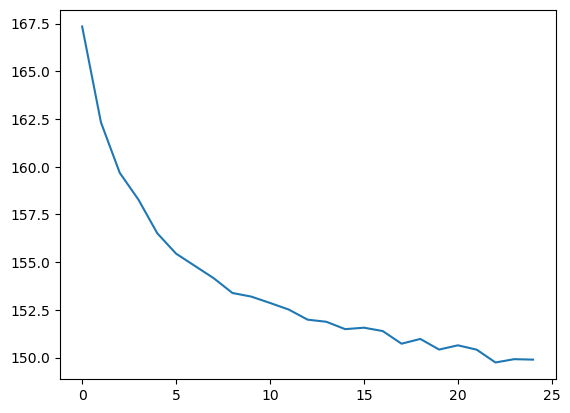

In [11]:
plt.figure()
plt.plot(val_loss)

We can visualize the "embedded" images in the 2D latent space

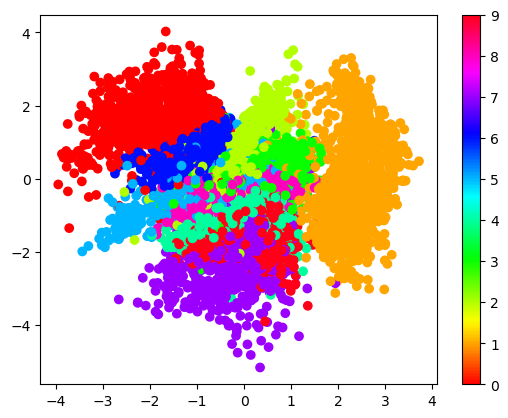

In [12]:
embed = []
for images, _ in (val_loader):
    embed.append(model.encode(images.to(device)).cpu())

embed = torch.cat(embed,axis=0)

plt.figure()
plt.scatter(embed[:,0,0].detach().numpy(),embed[:,0,1].detach().numpy(),
            c=val_loader.dataset.targets,cmap='hsv')
plt.colorbar()

Now we can also decode a grid of 2D pointas in this latent space to generate new images

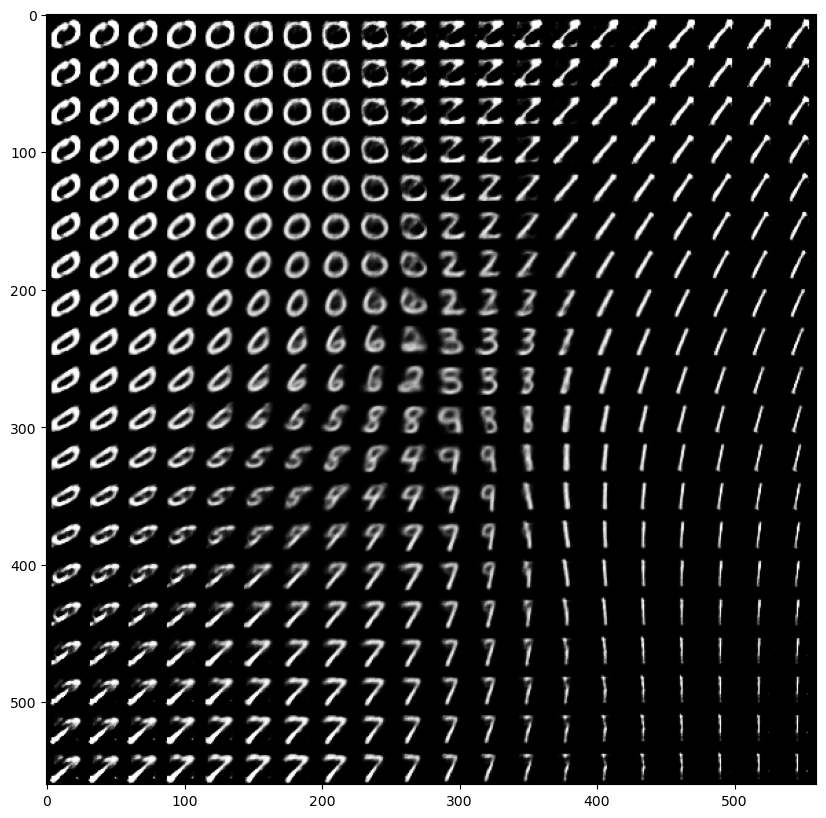

In [13]:
n = 20  # figure with 20x20 digits
digit_size = 28 # digit image dimensions
fig = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-5, 5, n)
grid_y = np.linspace(-5, 5, n)

for i, yi in enumerate(grid_x[::-1]):
    for j, xi in enumerate(grid_y):
        z = torch.tensor([[xi, yi]]).float().to(device)
        x_decoded = model.decode(z).cpu()
        digit = x_decoded[0].view(-1, 1, 28, 28).detach().numpy()
        fig[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(fig, cmap='gray')
plt.show()